# Compute error generated from the model used to fit the patterns


- author  :Sylvie Dagoret-Campagne
- affiliaiton : IJCLab/IN2P3/CNRS
- creation date : April 27th 2020
- update date :


Study the relative atmosphere relative to an ideal profile in **libradtran/info_verbose/RT_MPL_pp_us_sa_rtvis_z10_wv40_oz30_cld0000.OUT**
- no aerosol
- pwv =4 mm
- ozone = 3000 DU
- No extinction coefficient
- airmass = 1


Fit components:

- h2o,
- o2,
- o3




In [60]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import numpy as np
import pandas as pd
import os
import sys
%matplotlib inline

In [61]:
from astropy.io import fits

In [62]:
from pprint import pprint # we use this to pretty print some stuff later

In [63]:
from datetime import datetime,date
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [64]:
#to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10,6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [65]:
plt.rcParams.update({'figure.max_open_warning': 0}) # to see a large number of files

In [66]:
import timeit

In [67]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Configuration

## data

In [68]:
input_datafile="lsst_atm_10year_fittedabspatternsandsims.fits"

# Read File

In [69]:
hdu = fits.open(input_datafile)

In [70]:
hdu.info()

Filename: lsst_atm_10year_fittedabspatternsandsims.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      33   (1583, 3652)   float64   


## Header

In [71]:
hdr=hdu[0].header

In [72]:
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1583                                                  
NAXIS2  =                 3652                                                  
NBSIM   =                 3650                                                  
NPARAMS =                   15                                                  
NWL     =                  782                                                  
PFITPAR =                    0                                                  
PAR_H2O =                    0                                                  
PAR_O2  =                    1                                                  
PAR_O3  =                    2                                                  
PAR_A0  =                   

### decode the header

In [73]:
NBSIM   = hdr["NBSIM "]
NWL     = hdr["NWL"] 
DATAFIT = hdr["DATAFIT"]
DATASIM = hdr["DATASIM"]
DATAEND = hdr["DATAEND"]

In [74]:
# bins in wevelength
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSIM)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSIM), alpha=1)

## Data

In [75]:
data=hdu[0].data

In [76]:
#plt.imshow(data,origin="lower",vmin=0.9,vmax=0.96)

In [77]:
WL=data[0,DATAFIT:DATAFIT+NWL]

# Plot the differences

Text(0, 0.5, 'magnitude')

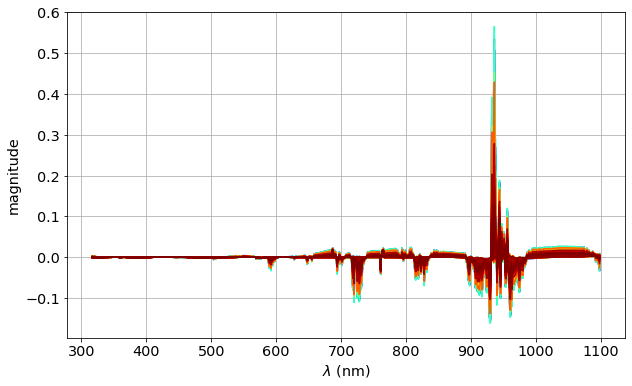

In [84]:
IDXMAX=int(NBSIM/10)

# bins in wevelength
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=IDXMAX)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(IDXMAX), alpha=1)

for IDX in np.arange(IDXMAX):
    fitprofile  = data[IDX+2,DATAFIT:DATAFIT+NWL]
    simprofile  = data[IDX+2,DATASIM:DATASIM+NWL]
    diffmag=-2.5*np.log10(fitprofile/simprofile)
    plt.plot(WL,diffmag,"-",color=all_colors[IDX])
plt.grid()
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("magnitude")

Text(0, 0.5, 'difference in relative profile')

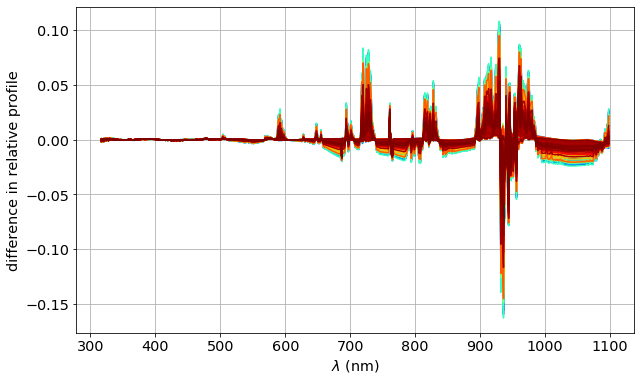

In [85]:
IDXMAX=int(NBSIM/10)

# bins in wevelength
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=IDXMAX)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(IDXMAX), alpha=1)

for IDX in np.arange(IDXMAX):
    fitprofile  = data[IDX+2,DATAFIT:DATAFIT+NWL]
    simprofile  = data[IDX+2,DATASIM:DATASIM+NWL]
    diffprofile = fitprofile - simprofile
    plt.plot(WL,diffprofile,"-",color=all_colors[IDX])
plt.grid()
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("difference in relative profile")